In [ ]:
import anndata as ad
import scanpy as sc
from scipy.stats import pearsonr, spearmanr, norminvgauss, invgauss, expon, entropy, lognorm, norm, gamma
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

from tqdm import tqdm
import copy
import pickle 
from multiprocessing import Pool

from utils import *

## Scanpy clustering

```
T Cell Markers	CD3D	ENSG00000167286
T Cell Markers	CD3E	ENSG00000198851
T Cell Markers	CD4	ENSG00000010610
Cytotoxic/CD8 T Cells	GNLY	ENSG00000115523
Cytotoxic/CD8 T Cells	GZMB	ENSG00000100453
B Cell Markers	CD79A	ENSG00000105369
B Cell Markers	CD79B	ENSG00000007312
Monocyte Markers	CD14	ENSG00000170458
Proliferating Erythrocytes	HBG1	ENSG00000213934
Proliferating Erythrocytes	HBG2	ENSG00000196565

https://scanpy.readthedocs.io/en/stable/tutorials/basics/index.html

In [2]:
import anndata as ad
data = ad.read_h5ad('/home/cat/proMonod/2024_10x_v4/filtered_RNA_data.h5ad')

/tmp/ipykernel_2824357/2450210296.py:15: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(data, resolution=0.2)


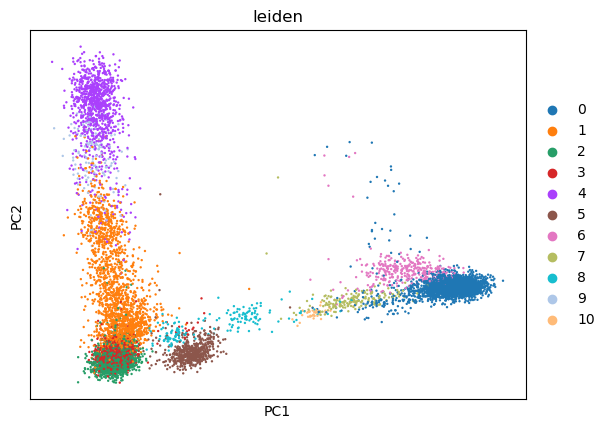

In [ ]:
# # Saving count data
data.layers["counts"] = data.X.copy()
sc.pp.normalize_total(data)
sc.pp.log1p(data)

sc.pp.highly_variable_genes(data, n_top_genes=2000)

# # PCA and neighborhood graph
sc.tl.pca(data)
sc.pp.neighbors(data)

# Clustering and t-SNE
sc.tl.leiden(data, resolution=0.2)
sc.pl.pca(data, color=["leiden"])

In [15]:
# Save clustered data
data.write_h5ad('/home/cat/proMonod/2024_10x_v4/clustered_10_filtered_RNA_data.h5ad')

In [4]:
data.var['gene_id'] = data.var_names.copy()
data.var_names = [ g.split('.')[0] for g in data.var['gene_id'] ]
data.var

,highly_variable,means,dispersions,dispersions_norm,gene_id
ENSG00000228037,False,1.142234e-02,0.220931,0.146676,ENSG00000228037.1
ENSG00000142611,False,1.540555e-04,0.451238,0.650991,ENSG00000142611.17
ENSG00000284616,False,1.000000e-12,NaN,NaN,ENSG00000284616.1
ENSG00000157911,False,3.961550e-02,0.255483,0.222336,ENSG00000157911.11
ENSG00000260972,False,1.000000e-12,NaN,NaN,ENSG00000260972.1
...,...,...,...,...,...
ENSG00000275063,False,5.865912e-04,0.555940,0.880263,ENSG00000275063.1
ENSG00000277856,False,9.758672e-04,0.644380,1.073924,ENSG00000277856.1
ENSG00000271254,False,5.238136e-02,0.200158,0.101189,ENSG00000271254.7
ENSG00000268674,False,1.000000e-12,NaN,NaN,ENSG00000268674.2


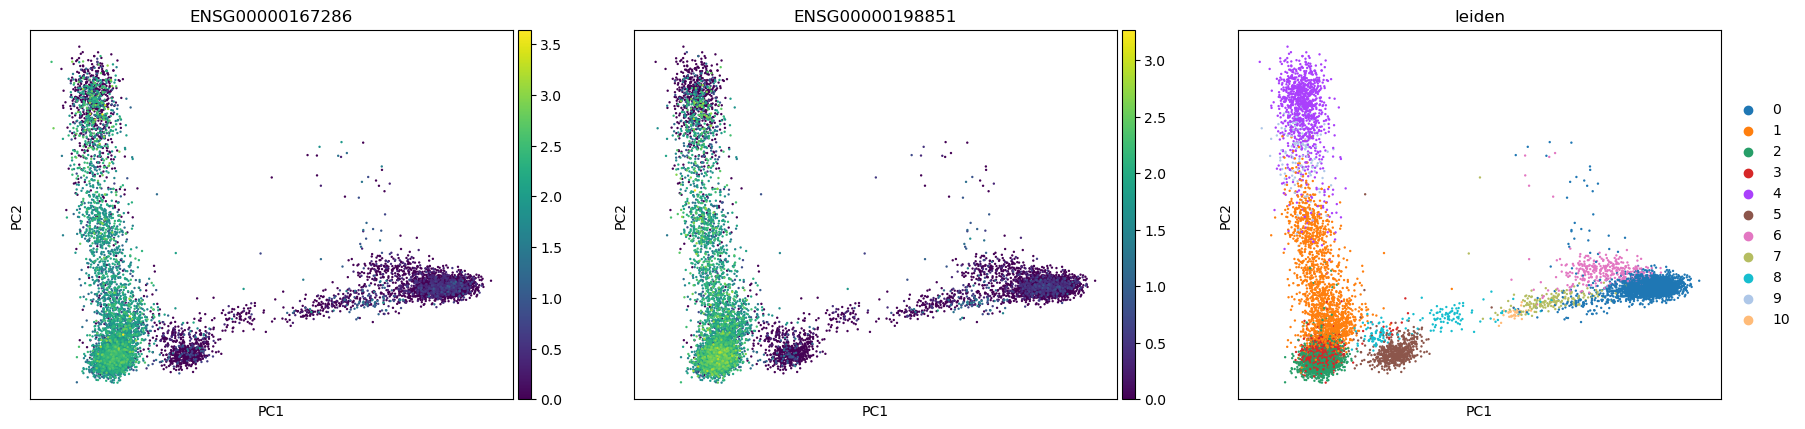

In [5]:
# T Cell: CD3
sc.pl.pca(data,color=['ENSG00000167286','ENSG00000198851',"leiden"])

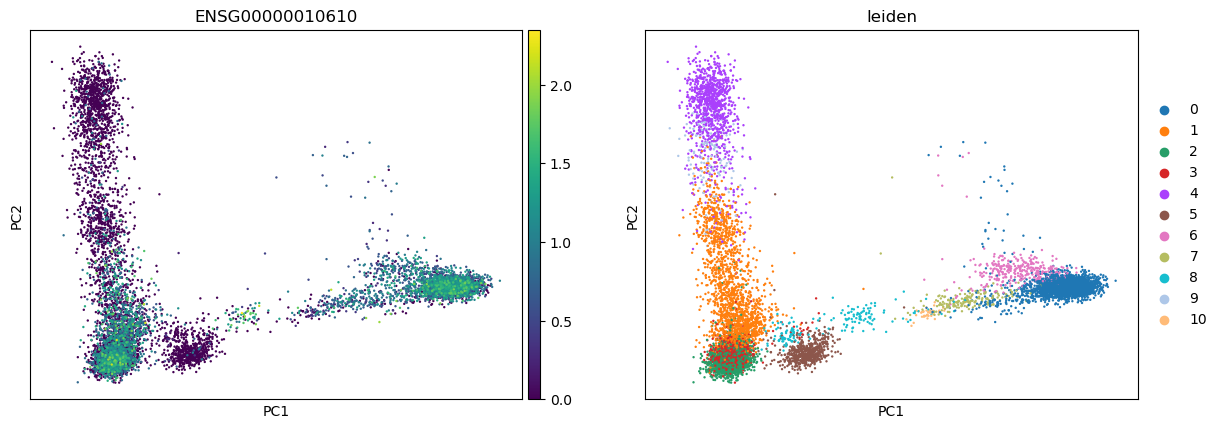

In [18]:
# Helper T Cell: CD4
sc.pl.pca(data,color=['ENSG00000010610',"leiden"])

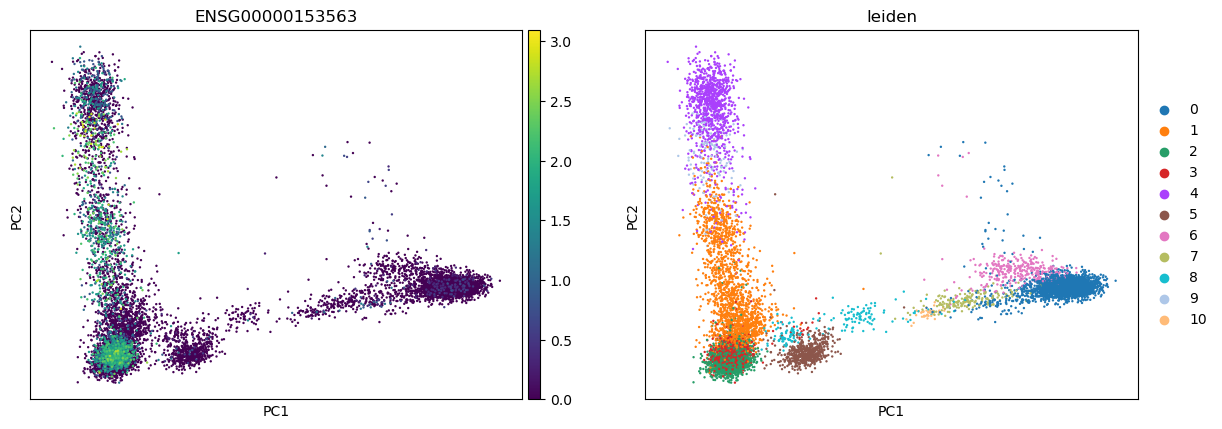

In [19]:
# Cytotoxic T Cell: CD8
sc.pl.pca(data,color=['ENSG00000153563',"leiden"])

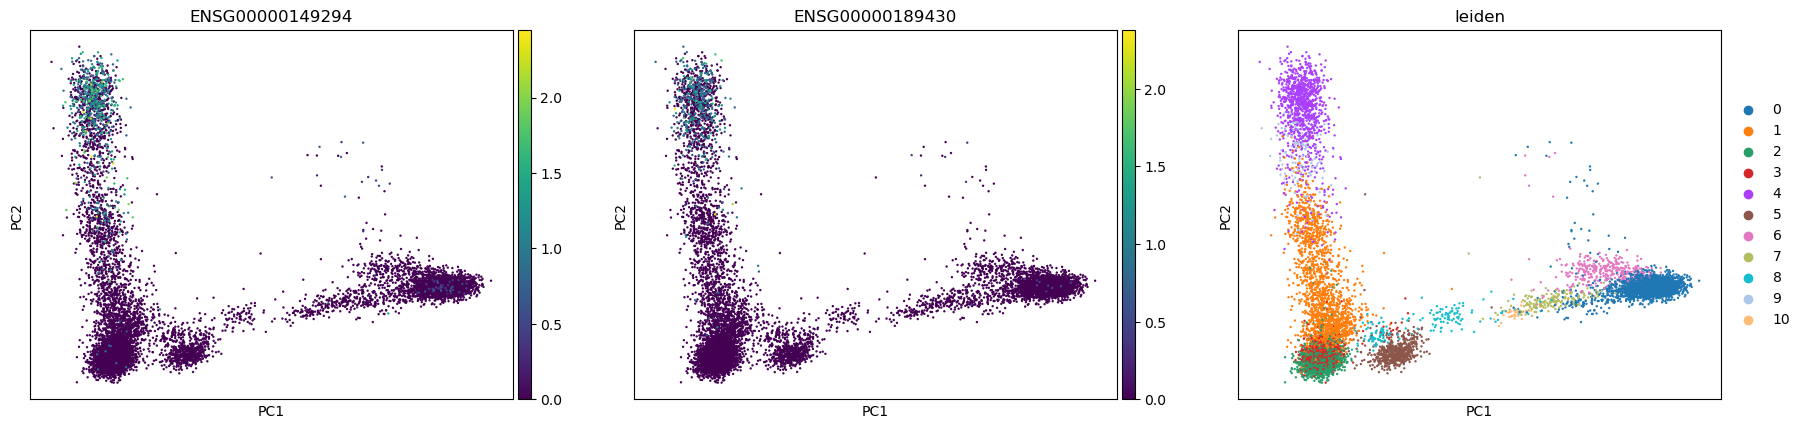

In [20]:
# NK cells: cd56
sc.pl.pca(data,color=['ENSG00000149294','ENSG00000189430',"leiden"])

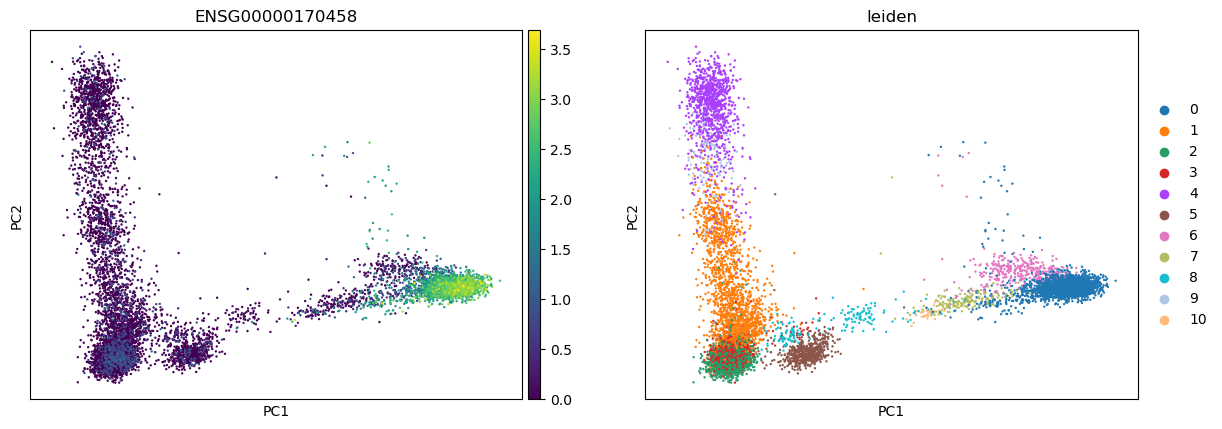

In [21]:
# Monocyte cells: cd14
sc.pl.pca(data,color=['ENSG00000170458',"leiden"], save='monocyte.png')

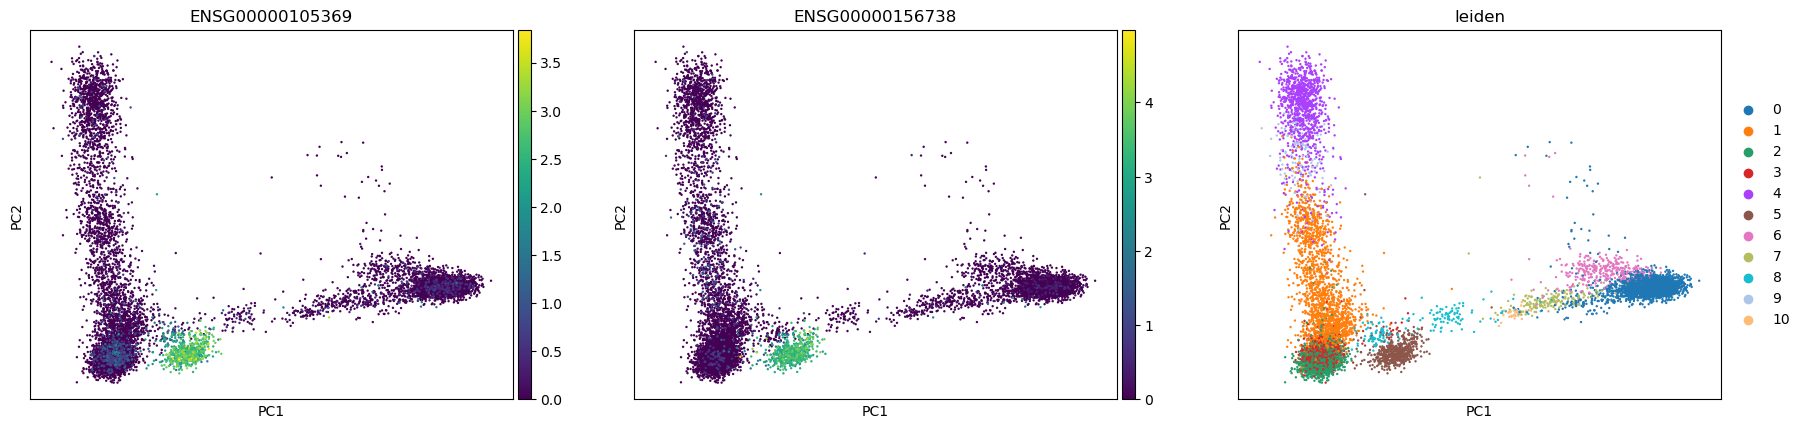

In [22]:
# B cells
sc.pl.pca(data,color=['ENSG00000105369','ENSG00000156738',"leiden"])

In [7]:
ensg_ids = {'CD4': 'ENSG00000010610', 'CD8': 'ENSG00000153563', 
            'CD3': 'ENSG00000198851', 'CD16': 'ENSG00000203747',
            'CD14': 'ENSG00000170458', 'CD11c': 'ENSG00000140678', 
            'CD19': 'ENSG00000177455', 
            'CD56': 'ENSG00000149294', 'CD45': 'ENSG00000081237'}

id_to_gene = {v:k for k,v in ensg_ids.items()}

## Plot spliced, protein expression in each cluster

In [8]:
import scanpy as sc
import matplotlib.pyplot as plt
import numpy as np

# --- Load AnnData objects
combined_adata = sc.read_h5ad('/home/cat/proMonod/2024_10x_v4/combined_adata_all.h5ad')
clustered = sc.read_h5ad('/home/cat/proMonod/2024_10x_v4/clustered_10_filtered_RNA_data.h5ad')

# --- Align by shared cells
common_cells = combined_adata.obs_names.intersection(clustered.obs_names)
combined_adata = combined_adata[common_cells].copy()
clustered = clustered[common_cells].copy()

# --- Retrieve clusters and genes
clusters = clustered.obs['leiden'].cat.categories
genes_to_plot = combined_adata.var_names

# --- Layout setup
n_clusters = len(clusters)
n_genes = len(genes_to_plot)
fig, axs = plt.subplots(n_clusters, n_genes, figsize=(3 * n_genes, 3 * n_clusters), sharex=False, sharey=False)

# Ensure axs is 2D
if n_clusters == 1:
    axs = np.expand_dims(axs, axis=0)
if n_genes == 1:
    axs = np.expand_dims(axs, axis=1)

# --- Plot each cluster × gene
for j, cluster in enumerate(clusters):
    cluster_cells = clustered.obs_names[clustered.obs['leiden'] == cluster]
    subset = combined_adata[combined_adata.obs_names.isin(cluster_cells), :]

    for i, gene in enumerate(genes_to_plot):
        ax = axs[j, i]
        spliced = subset.layers['spliced'][:, subset.var_names == gene].toarray().flatten()
        protein = subset.layers['protein'][:, subset.var_names == gene].toarray().flatten()

        # Compute local axis ranges (with small margin)
        xmin, xmax = np.min(spliced), np.max(spliced)
        ymin, ymax = np.min(protein), np.max(protein)
        margin_x = 0.05 * (xmax - xmin) if xmax > xmin else 1
        margin_y = 0.05 * (ymax - ymin) if ymax > ymin else 1
        ax.set_xlim(xmin - margin_x, xmax + margin_x)
        ax.set_ylim(ymin - margin_y, ymax + margin_y)

        ax.scatter(spliced, protein, s=1, alpha=0.6)

        # Titles and labels
        if j == 0:
            ax.set_title(id_to_gene[gene], fontsize=10)
        if i == 0:
            ax.set_ylabel(f'Cluster {cluster}', fontsize=9)
        ax.tick_params(axis='both', which='major', labelsize=7)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

# --- Shared labels and layout
fig.text(0.5, 0.02, 'Spliced expression', ha='center', fontsize=12)
fig.text(0.02, 0.5, 'Protein expression', va='center', rotation='vertical', fontsize=12)
fig.suptitle('Protein vs Spliced Expression per Cluster and Gene', fontsize=14, y=1.04)
fig.tight_layout(rect=[0.05, 0.05, 1, 1])  # Leaves space for labels

plt.savefig('all_clusters_genes_scatter_all_genes.png',
            dpi=300, bbox_inches='tight')
plt.close()


## Save monocyte barcodes and anndata object.


In [ ]:
# Select barcodes for Leiden cluster "0" (Monocytes)
mono_barcodes = data.obs.index[data.obs["leiden"] == "0"]

# Save to CSV
mono_barcodes.to_series().to_csv("monocyte_cd14_barcodes.csv", index=False, header=False)

# --- Filter AnnData
adata_mono_cells = combined_adata[combined_adata.obs_names.isin(mono_barcodes)].copy()

# --- Save filtered AnnData
adata_mono_cells.write("/home/cat/proMonod/2024_10x_v4/combined_adata_monocytes_all.h5ad")